In [1]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('températures_globales.csv',sep=',')
df.head()

Unnamed: 0  Year  Month  Anomaly-Gl  Uncertainty-Gl
0           0  1753      1      -1.264           3.651
1           1  1753      2      -1.985           4.124
2           2  1753      3       0.279           3.657
3           3  1753      4      -1.289           2.167
4           4  1753      5      -0.436           2.144

In [3]:
df.tail()
df.isna().sum()
df.duplicated().sum()
df = df.drop(columns='Unnamed: 0')

In [4]:
df['Périodes'] = pd.to_datetime(df['Year'].astype(str)+'-'+ df['Month'].astype(str))            # periode annee/mois/jour
df = df.drop(columns=['Year','Month'])                                                          # on supprime colonnes annees et mois
df =df.reindex(columns=['Périodes','Anomaly-Gl','Uncertainty-Gl'])                              # pour confort visuel 

df = df.rename({'Anomaly-Gl':'Anomalies de T.°','Uncertainty-Gl':'Incertitude T.° anomalie'},axis=1)

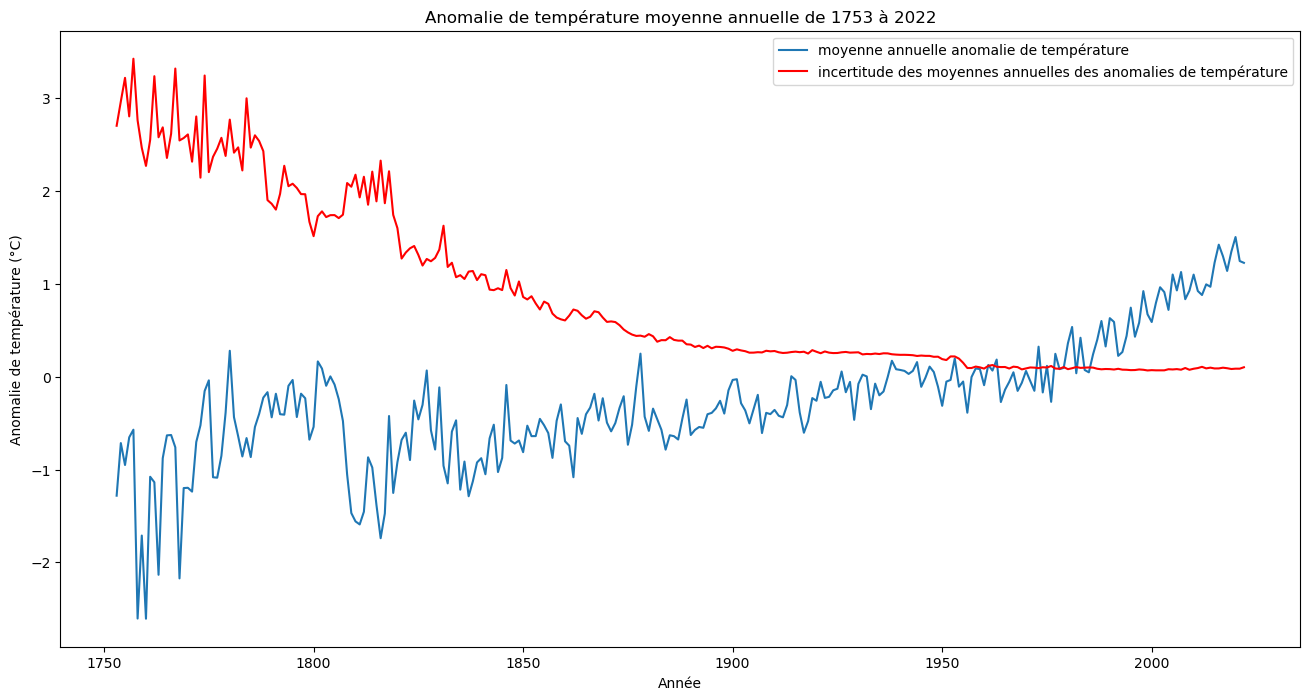

In [5]:
# Regrouper les données par année et calculer la moyenne de l'anomalie de température
df_annee_at = df.groupby(df['Périodes'].dt.year)['Anomalies de T.°'].mean()
df_annee_inc = df.groupby(df['Périodes'].dt.year)['Incertitude T.° anomalie'].mean()

# Tracer le graphique avec plt.plot()
plt.figure(figsize=(16,8))
plt.plot(df_annee_at.index, df_annee_at.values, label='moyenne annuelle anomalie de température')
plt.plot(df_annee_inc.index, df_annee_inc.values,color='red',label='incertitude des moyennes annuelles des anomalies de température')

# Ajouter les étiquettes d'axe et le titre
plt.xlabel('Année')
plt.ylabel('Anomalie de température (°C)')
plt.title('Anomalie de température moyenne annuelle de 1753 à 2022')
plt.legend();

In [6]:
df = df.loc [ df['Périodes']>= '1960-01-01']      # choix de travailler à partir de cette période pour fiabilité des mesures

In [7]:
df = df.rename({'Périodes':'ds','Anomalies de T.°':'y'},axis=1)
df = df.drop(columns='Incertitude T.° anomalie')
print(df.head())
print('\n')
print(df.tail())

             ds      y
2484 1960-01-01  0.076
2485 1960-02-01  0.549
2486 1960-03-01 -1.079
2487 1960-04-01 -0.282
2488 1960-05-01 -0.502


             ds      y
3235 2022-08-01  1.258
3236 2022-09-01  1.151
3237 2022-10-01  1.549
3238 2022-11-01  0.684
3239 2022-12-01  0.888


In [8]:
# Diviser les données en ensembles d'entrainement  et de test    coix volontaire 90% entrainement et 10% test 

cutoff_date = '2015-01-01'
train = df[df['ds'] < cutoff_date]
test = df[df['ds'] >= cutoff_date]

# Créer un modèle Prophet avec des hyperparamètres par défaut : modele additif 
model = Prophet(seasonality_mode='additive')

# Entraîner le modèle sur les données de formation
model.fit(train)

13:51:50 - cmdstanpy - INFO - Chain [1] start processing
13:51:50 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
future = model.make_future_dataframe(periods=50*12, freq='M')          # prévision sur 50 ans 
forecast = model.predict(future)

In [10]:
forecast.head()

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 1960-01-01 -0.147146   -0.446310    0.382772    -0.147146    -0.147146   
1 1960-02-01 -0.145898   -0.460766    0.346173    -0.145898    -0.145898   
2 1960-03-01 -0.144731   -0.503937    0.272596    -0.144731    -0.144731   
3 1960-04-01 -0.143483   -0.435297    0.361227    -0.143483    -0.143483   
4 1960-05-01 -0.142275   -0.619773    0.185752    -0.142275    -0.142275   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.105378              0.105378              0.105378  0.105378   
1        0.075245              0.075245              0.075245  0.075245   
2        0.042047              0.042047              0.042047  0.042047   
3        0.097158              0.097158              0.097158  0.097158   
4       -0.069401             -0.069401             -0.069401 -0.069401   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.105378      0.105378                   0.0   
1      0.075245      0.075245                   0.0   
2      0.042047      0.042047                   0.0   
3      0.097158      0.097158                   0.0   
4     -0.069401     -0.069401                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0 -0.041769  
1                         0.0                         0.0 -0.070653  
2                         0.0                         0.0 -0.102684  
3                         0.0                         0.0 -0.046325  
4                         0.0                         0.0 -0.211676

In [11]:
# Générer les prévisions pour l'ensemble d'entrainement 
train_forecast = model.predict(train)

# Mesurer la performance du modèle sur l'ensemble d entrainement

train_mae = mean_absolute_error(train['y'], train_forecast['yhat'][:len(train)])
train_mse = mean_squared_error(train['y'], train_forecast['yhat'][:len(train)])
train_rmse = mean_squared_error(train['y'], train_forecast['yhat'][:len(train)], squared=False)
train_squared = r2_score(train['y'], train_forecast['yhat'][:len(train)])

                         
                        
print("Métriques de performance du modèle d'entrainement :")


print("MAE : ", train_mae)
print("MSE : ", train_mse)
print("RMSE : ", train_rmse)
print("R²   : ", train_squared)

Métriques de performance du modèle d'entrainement :
MAE :  0.24086827422347568
MSE :  0.09715662540937453
RMSE :  0.3116995755681655
R²   :  0.5996524101264358


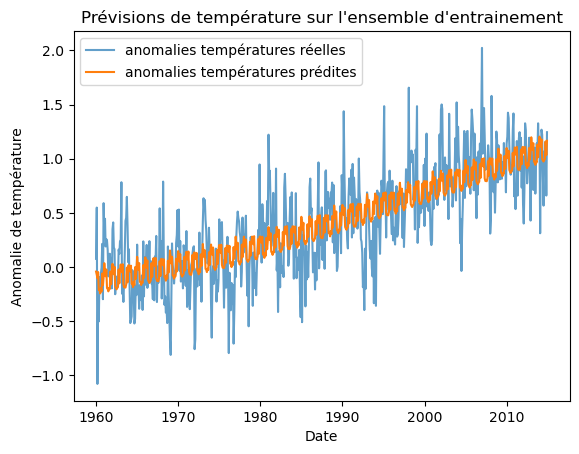

In [12]:
# Afficher les prévisions pour l'ensemble d'entrainement : 

plt.plot( train['ds'] ,train['y'], label='anomalies températures réelles',alpha=0.7)
plt.plot( train['ds'] ,train_forecast['yhat'], label='anomalies températures prédites') 
plt.title("Prévisions de température sur l'ensemble d'entrainement")
plt.xlabel("Date")
plt.ylabel("Anomalie de température")
plt.legend()
plt.show();

Analyse métrique avec confirmation visuelle des résultats :Ces métriques peuvent être interprétées comme suit :

MAE (Mean Absolute Error) : il s'agit de la moyenne des écarts absolus entre les valeurs prédites et les valeurs réelles. Plus le MAE est faible, meilleure est la performance du modèle. Dans ce cas, le MAE est de 0.216, ce qui signifie que les prédictions du modèle ont en moyenne une erreur absolue de 0.216 par rapport aux valeurs réelles.

MSE (Mean Squared Error) : il s'agit de la moyenne des carrés des écarts entre les valeurs prédites et les valeurs réelles. Plus le MSE est faible, meilleure est la performance du modèle. Dans ce cas, le MSE est de 0.095, ce qui est relativement faible et suggère que le modèle fait des prédictions précises.

RMSE (Root Mean Squared Error) : il s'agit de la racine carrée du MSE. Le RMSE est une mesure de la dispersion des erreurs. Plus le RMSE est faible, meilleure est la performance du modèle. Dans ce cas, le RMSE est de 0.308, ce qui est relativement faible et suggère que le modèle est capable de faire des prédictions précises.

R² (R-squared) : il s'agit d'une mesure de l'ajustement du modèle aux données. R² varie entre 0 et 1, où 1 indique un ajustement parfait. Dans ce cas, le R² est de 0.6, ce qui indique que le modèle explique environ 60% de la variance des données. Bien que ce ne soit pas un ajustement parfait, un R² de 0.6 est considéré comme un bon ajustement pour de nombreux problèmes de prédiction.

En conclusion, les métriques de performance du modèle Prophet suggèrent que le modèle est capable de faire des prédictions précises pour les anomalies de température dans les 50 années à venir. Cependant, il est important de noter que ces métriques ne fournissent qu'une indication de la performance du modèle et qu'il est toujours important de vérifier la qualité des prédictions à l'aide d'autres outils et méthodes.    


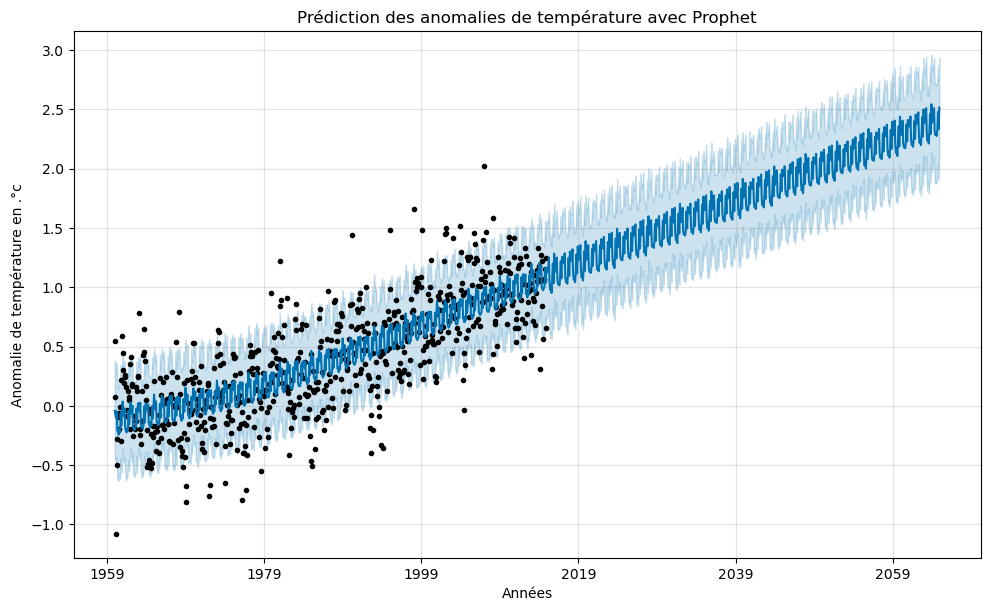

In [13]:
# Afficher le graphique de la prédiction                                      # points noirs : données d'entrainement
                                                                              # prévision ligne bleue avec des limites supérieure et inférieure en zone ombrée bleue clair 
fig1 = model.plot(forecast)

plt.xlabel("Années")
plt.ylabel("Anomalie de température en .°c")
plt.title("Prédiction des anomalies de température avec Prophet")
plt.show();

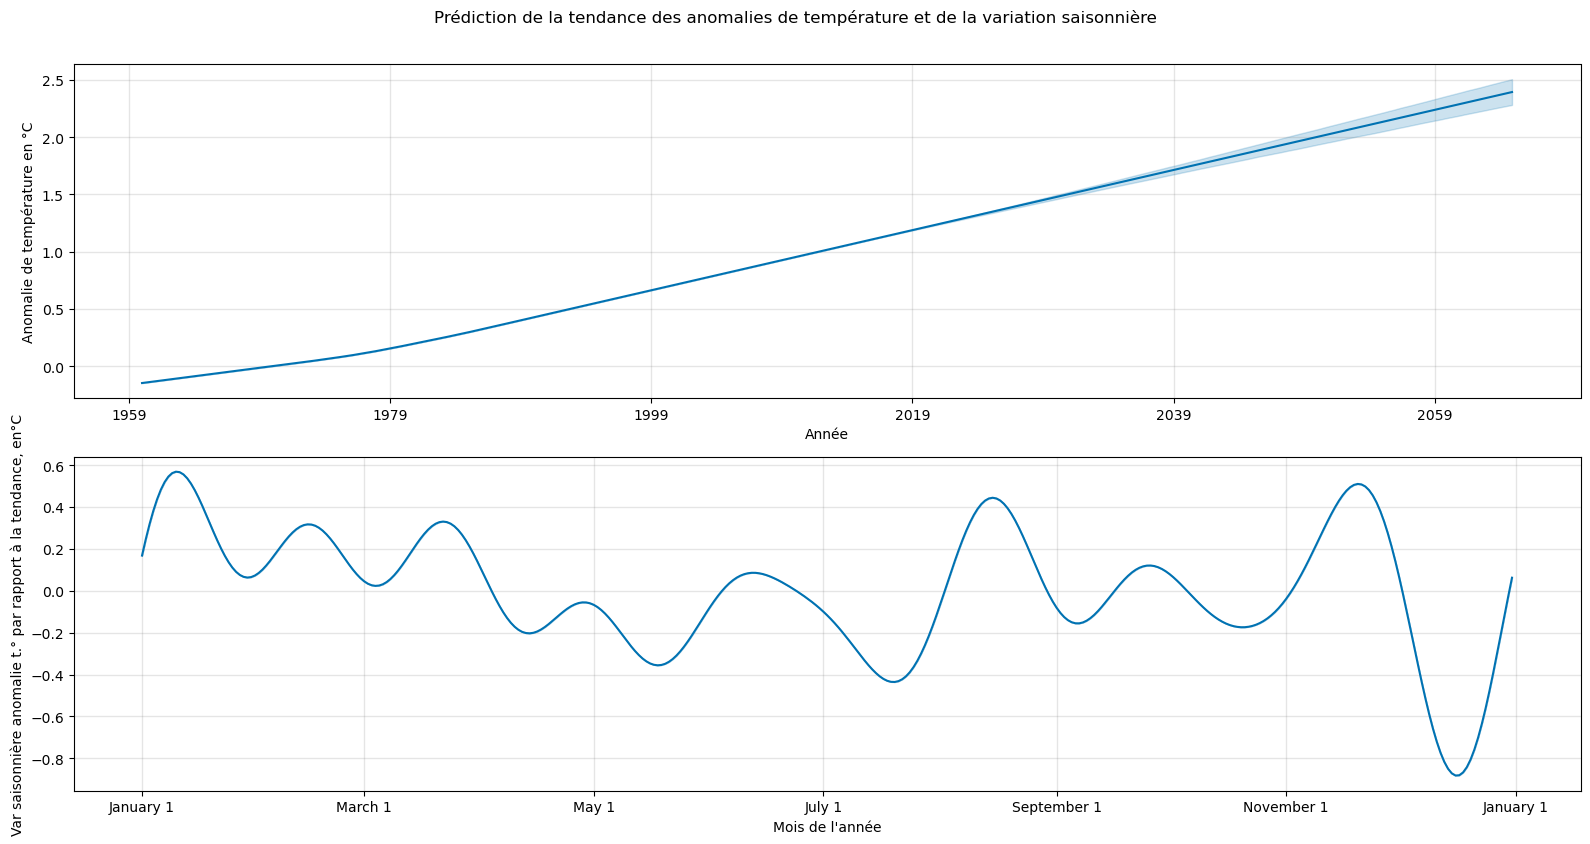

In [14]:
# Afficher les composantes de la prédiction (tendance, saisonnalité)

fig2 = model.plot_components(forecast,figsize=(16,8))
plt.suptitle('Prédiction de la tendance des anomalies de température et de la variation saisonnière',y=1.05, fontsize=12)
axes = fig2.get_axes()
axes[0].set_xlabel('Année')
axes[0].set_ylabel('Anomalie de température en °C')
axes[1].set_xlabel("Mois de l'année")
axes[1].set_ylabel("Var saisonnière anomalie t.° par rapport à la tendance, en°C")
plt.show();

In [ ]:
# on observe une tendance à la hausse mais aussi une saisonnalité mi août et le mois de décembre où l on constate ;: qu il fait plus chaud que la moyenne des autres mois dans l'année

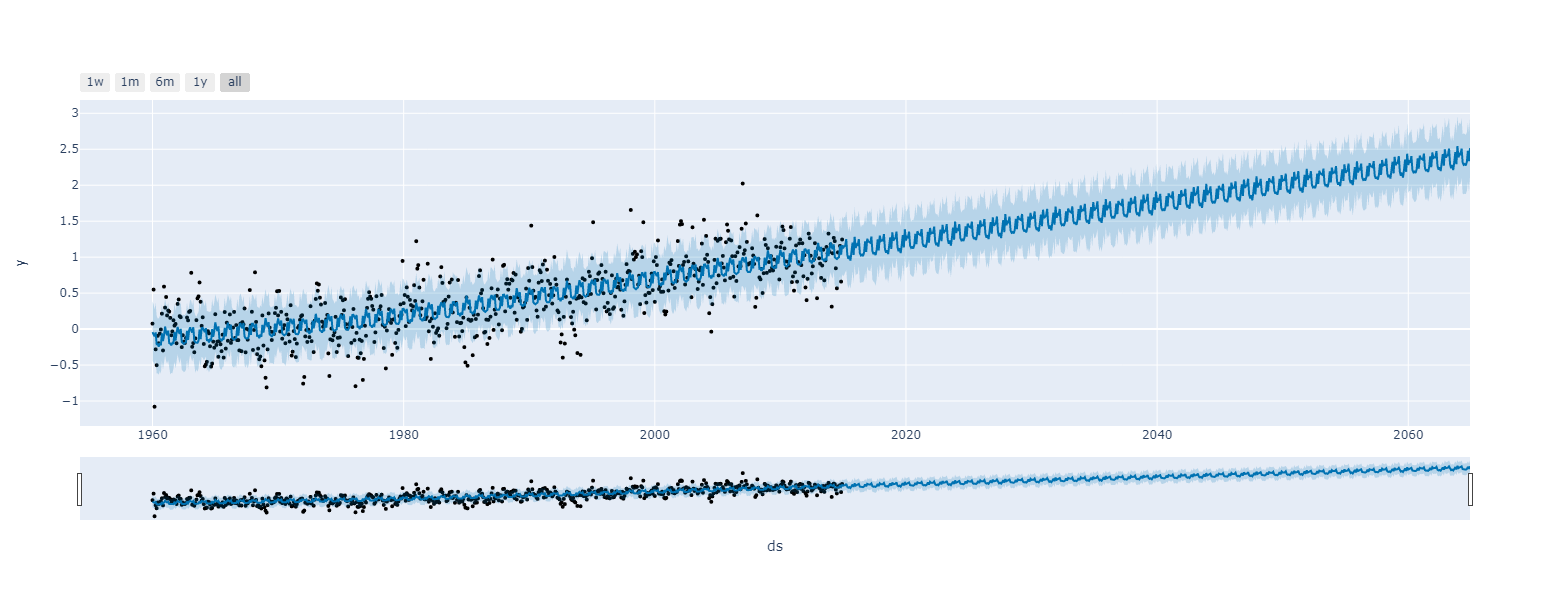

In [15]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model,forecast)

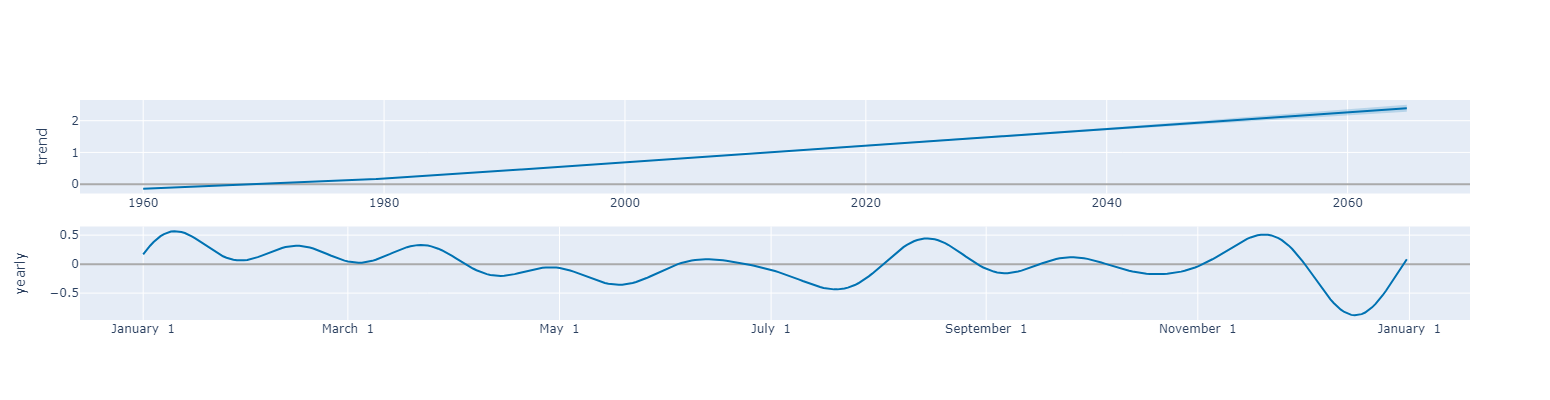

In [16]:
plot_components_plotly(model, forecast)                   # figure interactive des composants 

In [ ]:
# utilisation de métriques pour mesure la performance du modèle sur les données test 

In [39]:
periods=len(test)
periods

96

In [17]:
future_dates = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future_dates)
forecast

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   1960-01-01 -0.147146   -0.435861    0.357599    -0.147146    -0.147146   
1   1960-02-01 -0.145898   -0.490939    0.345440    -0.145898    -0.145898   
2   1960-03-01 -0.144731   -0.482156    0.292710    -0.144731    -0.144731   
3   1960-04-01 -0.143483   -0.436697    0.351452    -0.143483    -0.143483   
4   1960-05-01 -0.142275   -0.609313    0.220985    -0.142275    -0.142275   
..         ...       ...         ...         ...          ...          ...   
751 2015-03-03  1.087018    0.700801    1.510370     1.087018     1.087018   
752 2015-03-04  1.087090    0.705767    1.495428     1.087090     1.087090   
753 2015-03-05  1.087162    0.698081    1.515594     1.087162     1.087162   
754 2015-03-06  1.087234    0.713457    1.499889     1.087234     1.087234   
755 2015-03-07  1.087305    0.720224    1.520462     1.087305     1.087305   

     additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0          0.105378              0.105378              0.105378  0.105378   
1          0.075245              0.075245              0.075245  0.075245   
2          0.042047              0.042047              0.042047  0.042047   
3          0.097158              0.097158              0.097158  0.097158   
4         -0.069401             -0.069401             -0.069401 -0.069401   
..              ...                   ...                   ...       ...   
751        0.029417              0.029417              0.029417  0.029417   
752        0.024178              0.024178              0.024178  0.024178   
753        0.023460              0.023460              0.023460  0.023460   
754        0.027302              0.027302              0.027302  0.027302   
755        0.035606              0.035606              0.035606  0.035606   

     yearly_lower  yearly_upper  multiplicative_terms  \
0        0.105378      0.105378                   0.0   
1        0.075245      0.075245                   0.0   
2        0.042047      0.042047                   0.0   
3        0.097158      0.097158                   0.0   
4       -0.069401     -0.069401                   0.0   
..            ...           ...                   ...   
751      0.029417      0.029417                   0.0   
752      0.024178      0.024178                   0.0   
753      0.023460      0.023460                   0.0   
754      0.027302      0.027302                   0.0   
755      0.035606      0.035606                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                           0.0                         0.0 -0.041769  
1                           0.0                         0.0 -0.070653  
2                           0.0                         0.0 -0.102684  
3                           0.0                         0.0 -0.046325  
4                           0.0                         0.0 -0.211676  
..                          ...                         ...       ...  
751                         0.0                         0.0  1.116435  
752                         0.0                         0.0  1.111268  
753                         0.0                         0.0  1.110622  
754                         0.0                         0.0  1.114535  
755                         0.0                         0.0  1.122912  

[756 rows x 16 columns]

In [18]:
# Mesurer la performance du modèle en comparant les prévisions aux valeurs réelles de l'ensemble de test

test_forecast = model.predict(test)
y_true =  test["y"]
y_pred =  test_forecast['yhat']                                       

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
test_squared = r2_score(y_true,y_pred)                        

print("Métriques de performance du modèle prophet :")
print("MAE : ", mae)
print("MSE : ", mse)
print("RMSE : ", rmse)
print("R²   : ", test_squared)

Métriques de performance du modèle prophet :
MAE :  0.21649882196325512
MSE :  0.0950327379205984
RMSE :  0.30827380349390443
R²   :  0.03193757857880586


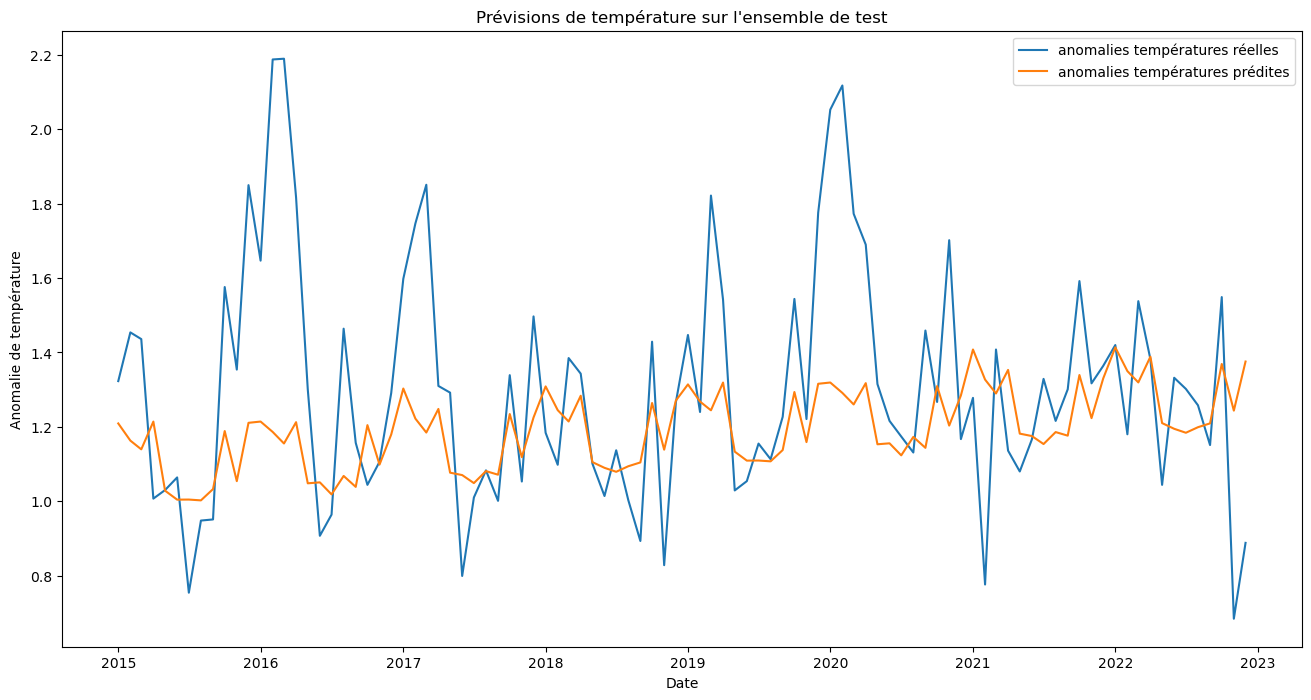

In [19]:

# Afficher les prévisions pour l'ensemble de test
plt.figure(figsize=(16,8))
plt.plot( test['ds'] ,y_true, label='anomalies températures réelles')
plt.plot( test['ds'] ,y_pred, label='anomalies températures prédites') 
plt.title("Prévisions de température sur l'ensemble de test")
plt.xlabel("Date")
plt.ylabel("Anomalie de température")
plt.legend()
plt.show();

'''Selon l’Organisation météorologique mondiale (OMM), l’année 2016 restera dans les annales: température moyenne record, banquise exceptionnellement réduite et poursuite inexorable de la hausse du niveau de la mer et du réchauffement des océans...
Ce compte rendu confirme que l'année 2016 est la plus chaude qui ait jamais été enregistrée: la hausse de la température par rapport à l'époque préindustrielle atteint, chose remarquable, 1,1 °C, soit 0,06 °C de plus que le record précédent établi en 2015. Cette augmentation de la température moyenne s'inscrit dans la logique des autres changements intervenant dans le système climatique», a souligné le Secrétaire général de l'OMM, Petteri Taalas.'''    Ces commentaires données par l'OMM explique cet écart flagrant entre la prédiction pour 2016 et l'anomalie de température mesurée .

2017 est la 2e année la plus chaude sur Terre, d’après NCEP-NCAR

2020 est en passe de devenir l’une des trois années les plus chaudes jamais enregistrées


Les températures extrèmes que l on a eu en 2016-2017-2020 le modèle ne pouvait pas les anticiper , ces valeurs montrent les limites de notre modèle : on peut prévoir une tendance sur l'avenir mais il est difficile de prévoir des annnées qui battent des records ! 


l analayse des métriques avec la visualisation des prédictions sur le jeu test :

Ces métriques indiquent que le modèle Prophet n'a pas bien généralisé sur les données de test, car les valeurs des métriques de performance sont relativement élevées. En particulier, le MAE et le RMSE indiquent que le modèle fait des prédictions en moyenne à environ 0.22 de l'écart absolu et 0.31 de l'écart type de la véritable valeur, respectivement. De plus, le R² est très faible, ce qui signifie que le modèle n'explique qu'une très petite proportion de la variance dans les données de test.

Sur une période de 9 ans , on a 3 années exceptionnelles en terme de record de température qui impact donc la performance de notre modèle .

